In [80]:
import pandas as pd
import numpy as np

from statsmodels.discrete.discrete_model import Logit
# And some functions we will need
from scipy.special import logit
import matplotlib.pyplot as plt
# start by bringing in the dataset

df = pd.read_pickle("../data/set_df.pkl") 

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7257 entries, 11 to 166605
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   set_id                7257 non-null   int64         
 1   latitude              7257 non-null   float64       
 2   longitude             7257 non-null   float64       
 3   dt                    7257 non-null   datetime64[ns]
 4   elevation             7257 non-null   int64         
 5   American plaice       7257 non-null   bool          
 6   Atlantic cod          7257 non-null   bool          
 7   Atlantic herring      7257 non-null   bool          
 8   Redfish unidentified  7257 non-null   bool          
 9   American lobster      7257 non-null   bool          
 10  Snow crab             7257 non-null   bool          
dtypes: bool(6), datetime64[ns](1), float64(2), int64(2)
memory usage: 382.7 KB


In [82]:
# we'll start with redfish since they should be an easy one to predict
# species = 'Snow crab'
# species = 'Redfish unidentified'
# species = 'American lobster'
species = 'American plaice'
species = 'Atlantic cod'
species = 'Atlantic herring'

predictors = ['latitude', 'longitude',]# 'elevation']
m = Logit(df[species], df[predictors])
m = m.fit()

Optimization terminated successfully.
         Current function value: 0.567740
         Iterations 6


In [83]:
m.params


latitude    -1.022472
longitude   -0.764028
dtype: float64

In [84]:
print(m.summary2())


                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: Atlantic herring Pseudo R-squared: 0.155    
Date:               2024-04-12 21:40 AIC:              8244.1783
No. Observations:   7257             BIC:              8257.9577
Df Model:           1                Log-Likelihood:   -4120.1  
Df Residuals:       7255             LL-Null:          -4876.3  
Converged:          1.0000           LLR p-value:      0.0000   
No. Iterations:     6.0000           Scale:            1.0000   
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
latitude    -1.0225    0.0297  -34.4787  0.0000  -1.0806  -0.9643
longitude   -0.7640    0.0223  -34.2514  0.0000  -0.8077  -0.7203


In [85]:
df.loc[:, 'p'] = m.predict(df[predictors])

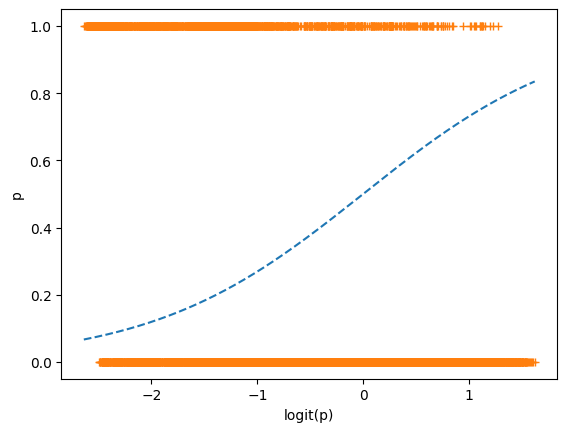

In [86]:
df = df.sort_values(by = ['p'], axis = 0)
plt.plot(logit(df.p), df.p, '--')
plt.plot(logit(df.p), df["Redfish unidentified"], '+')
plt.xlabel('logit(p)')
plt.ylabel('p')
plt.show()

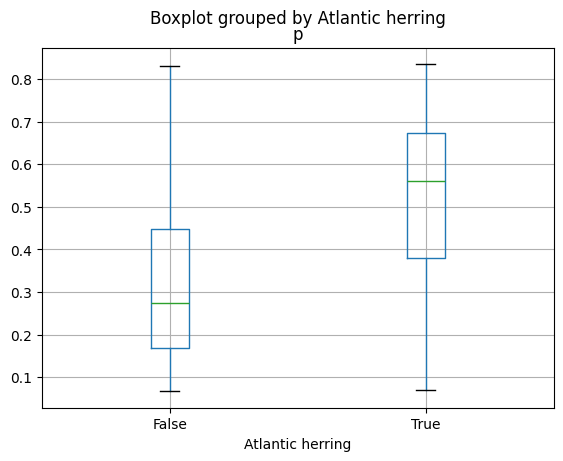

In [87]:
df.boxplot(column='p', by = species)
plt.show()

In [88]:
df.loc[:, 'yhat'] = (df.p > 0.5) * 1
df.yhat.value_counts()

0    4685
1    2572
Name: yhat, dtype: int64

In [89]:
pd.crosstab(df["Redfish unidentified"], df.yhat)


yhat,0,1
Redfish unidentified,,
False,3180,2438
True,1505,134


In [90]:
conf_mat = m.pred_table()
conf_mat

array([[3559.,  814.],
       [1126., 1758.]])

In [91]:
tn, fp, fn, tp = conf_mat.flatten()
print (tn, fp, fn, tp)

3559.0 814.0 1126.0 1758.0


In [92]:
acc = (tp + tn) / np.sum(conf_mat)
print ("Accuraccy of the model is: %1.2f" % acc)

Accuraccy of the model is: 0.73


In [93]:
mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
print ("Mathews correlation coefficient between the estimates and the true response is: %1.2f" % mcc)

Mathews correlation coefficient between the estimates and the true response is: 0.43


In [94]:
prc = tp / (tp + fp)
rec = tp / (tp + fn)
print ("Model's precision is %1.2f and it's recall is %1.2f" % (prc, rec))

Model's precision is 0.68 and it's recall is 0.61


In [95]:
# Set discrimination thresholds
ths = np.arange(0., 1.0, 0.025)

# Containers
sensitivity = []
specificity = []
accuracy = []
matthews = []

# Main loop
for th in ths:
    # Generate estimates
    conf_mat = m.pred_table(threshold=th)
    
    # Extract TN, FP, ...
    tn, fp, fn, tp = conf_mat.flatten()
    
    # Calculate sensitivity and specificity
    sens = (1. * tp) / (tp + fn)
    spec = (1. * tn) / (tn + fp)    
    
    # Calculate ACC and MCC
    acc = (tp + tn) / np.sum(conf_mat)
    mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))    

    # Add to containers
    sensitivity.append(sens)
    specificity.append(spec)
    accuracy.append(acc)
    matthews.append(mcc)

/tmp/ipykernel_11899/59817041.py:24: RuntimeWarning: invalid value encountered in scalar divide
  mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))


In [96]:
# Bind all the numbers together
roc = pd.DataFrame({'discret_thr' : ths, 
                    'sensitivity' : sensitivity, 
                    'specificity' : specificity,
                    '_specificity' : [1 - x for x in specificity],
                    'accuracy' : accuracy, 
                    'matthews' : matthews})

# Sort by 1 - specificity so we can plot it easily
roc = roc.sort_values(by = "_specificity")

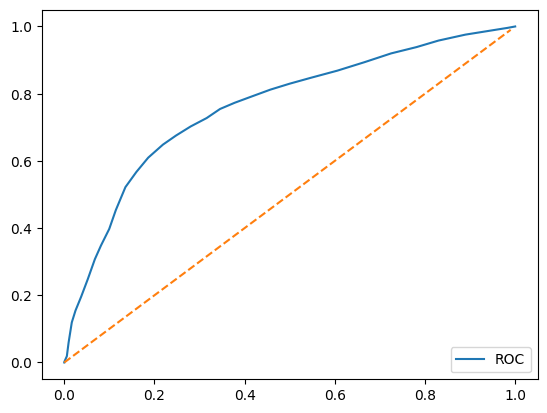

In [97]:
plt.plot(roc._specificity, roc.sensitivity, label = 'ROC')
plt.plot(np.arange(0., 1., 0.01), 
         np.arange(0., 1., 0.01), 
         '--')

plt.legend(loc = 4)

In [98]:
auc = np.trapz(y = roc.sensitivity, x = roc._specificity)
print ("Area under ROC curve = %1.2f" % auc)


Area under ROC curve = 0.76


In [99]:
# Where threshold equal 0.5
idx_default_th = np.where(roc.discret_thr == 0.5)[0][0]

# Max sum of spec and sens
idx_youdensj = np.argmax(roc.sensitivity + roc.specificity)

 # Balanced spec and sens
idx_ballance = np.argmin(np.abs(roc.sensitivity - roc.specificity))

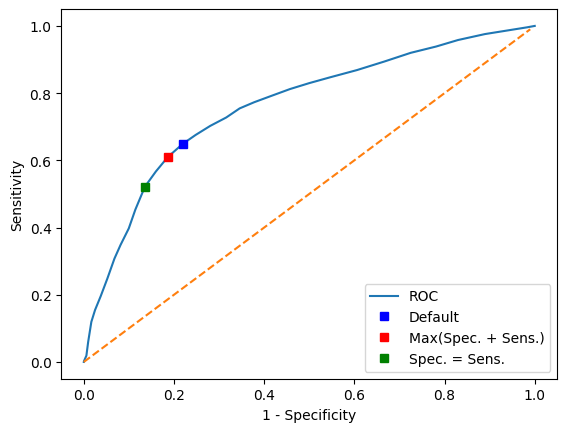

In [100]:
plt.plot(roc._specificity, roc.sensitivity, label = 'ROC')

plt.plot(np.arange(0., 1., 0.01), 
         np.arange(0., 1., 0.01), 
         '--')

plt.plot(roc._specificity[idx_default_th], 
         roc.sensitivity[idx_default_th], 
         's', color = 'blue',
         label = 'Default')

plt.plot(roc._specificity[idx_youdensj], 
         roc.sensitivity[idx_youdensj], 
         's', color = 'red',
         label = 'Max(Spec. + Sens.)')

plt.plot(roc._specificity[idx_ballance], 
         roc.sensitivity[idx_ballance], 
         's', color = 'green', 
         label = 'Spec. = Sens.')


plt.legend(loc = 4)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()


In [101]:
m.pred_table(threshold=roc.discret_thr[idx_youdensj])


array([[3559.,  814.],
       [1126., 1758.]])

In [102]:
m.pred_table(threshold=roc.discret_thr[idx_ballance])


array([[3780.,  593.],
       [1379., 1505.]])

In [103]:
J = max(roc.sensitivity + roc.specificity - 1)
print ('Youden\'s J = %1.2f' % J)

Youden's J = 0.43


In [104]:
print ('Odds mean: %1.2f' % np.mean(df['p']))
print ('Response mean: %1.2f' % np.mean(df[species]))

Odds mean: 0.40
Response mean: 0.40


In [105]:
print ('Predicted positives #: %i' % np.sum(df['p'] > 0.5))
print ('True positives #: %i' % np.sum(df[species] > 0.5))

Predicted positives #: 2572
True positives #: 2884


In [106]:
print (conf_mat)

[[4373.    0.]
 [2884.    0.]]


In [107]:
# Predicted negatives and positives
conf_mat.sum(axis = 0)

array([7257.,    0.])

In [108]:
# Actual negatives and positives
conf_mat.sum(axis = 1)

array([4373., 2884.])

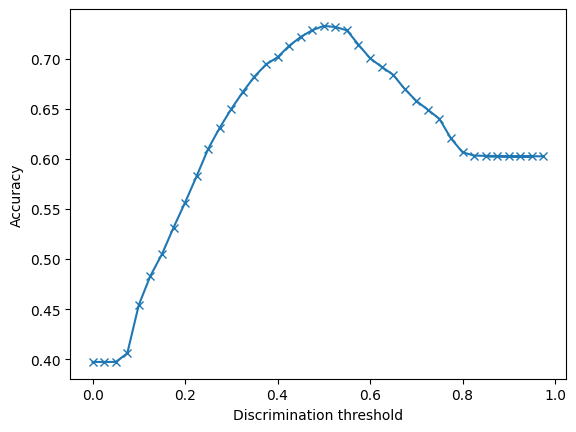

In [109]:
plt.plot(roc.discret_thr, roc.accuracy, 'x-')
plt.xlabel('Discrimination threshold')
plt.ylabel('Accuracy')
plt.show()

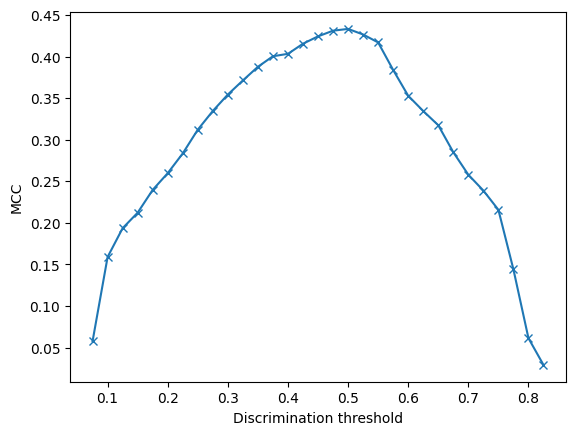

In [110]:
plt.plot(roc.discret_thr, roc.matthews, 'x-')
plt.xlabel('Discrimination threshold')
plt.ylabel('MCC')
plt.show()

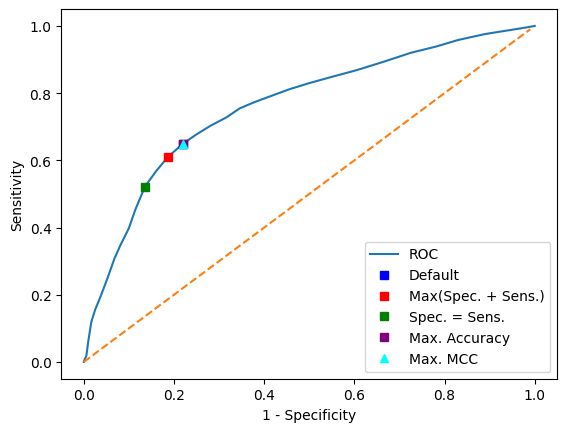

In [111]:
idx_maxacc = np.argmax(roc.accuracy)
idx_maxmcc = np.argmax(roc.matthews)

plt.plot(roc._specificity, roc.sensitivity, label = 'ROC')

plt.plot(np.arange(0., 1., 0.01), 
         np.arange(0., 1., 0.01), 
         '--')

plt.plot(roc._specificity[idx_default_th], 
         roc.sensitivity[idx_default_th], 
         's', color = 'blue',
         label = 'Default')

plt.plot(roc._specificity[idx_youdensj], 
         roc.sensitivity[idx_youdensj], 
         's', color = 'red',
         label = 'Max(Spec. + Sens.)')

plt.plot(roc._specificity[idx_ballance], 
         roc.sensitivity[idx_ballance], 
         's', color = 'green', 
         label = 'Spec. = Sens.')

plt.plot(roc._specificity[idx_maxacc], 
         roc.sensitivity[idx_maxacc], 
         's', color = 'purple',
         label = 'Max. Accuracy')

plt.plot(roc._specificity[idx_maxmcc], 
         roc.sensitivity[idx_maxmcc], 
         '^', color = 'cyan', 
         label = 'Max. MCC')

plt.legend(loc = 4)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()


In [115]:
elevation_xa = pd.read_pickle("../data/elevation_xa.pkl")


elevation_df = elevation_xa.to_dataframe()
elevation_df = elevation_df.reset_index()
elevation_df['p'] = m.predict(elevation_df[["lat", "lon",]])# "elevation"]])

elevation_df



,lat,lon,elevation,p
0,45.022917,-68.418750,86,0.998052
1,45.022917,-68.414583,87,0.998046
2,45.022917,-68.410417,88,0.998040
3,45.022917,-68.406250,93,0.998034
4,45.022917,-68.402083,95,0.998027
...,...,...,...,...
4090733,51.589583,-57.631250,219,0.000164
4090734,51.589583,-57.627083,219,0.000163
4090735,51.589583,-57.622917,211,0.000163
4090736,51.589583,-57.618750,207,0.000162


In [116]:
prob_array = elevation_df["p"].to_numpy()

In [117]:
prob_array = prob_array.reshape(elevation_xa.data.shape)

prob_xa = elevation_xa.copy()

prob_xa.data = prob_array

pd.to_pickle(prob_xa, "../data/prob_xa.pkl")

In [ ]:
# elevation_xa.plot()

In [ ]:
# prob_xa.plot()

In [118]:
species_df = pd.read_pickle("../data/species_df.pkl")
species_code_lookup = pd.read_pickle("../data/species_code_lookup.pkl")

(45.6930833333333, 49.1464166666667)

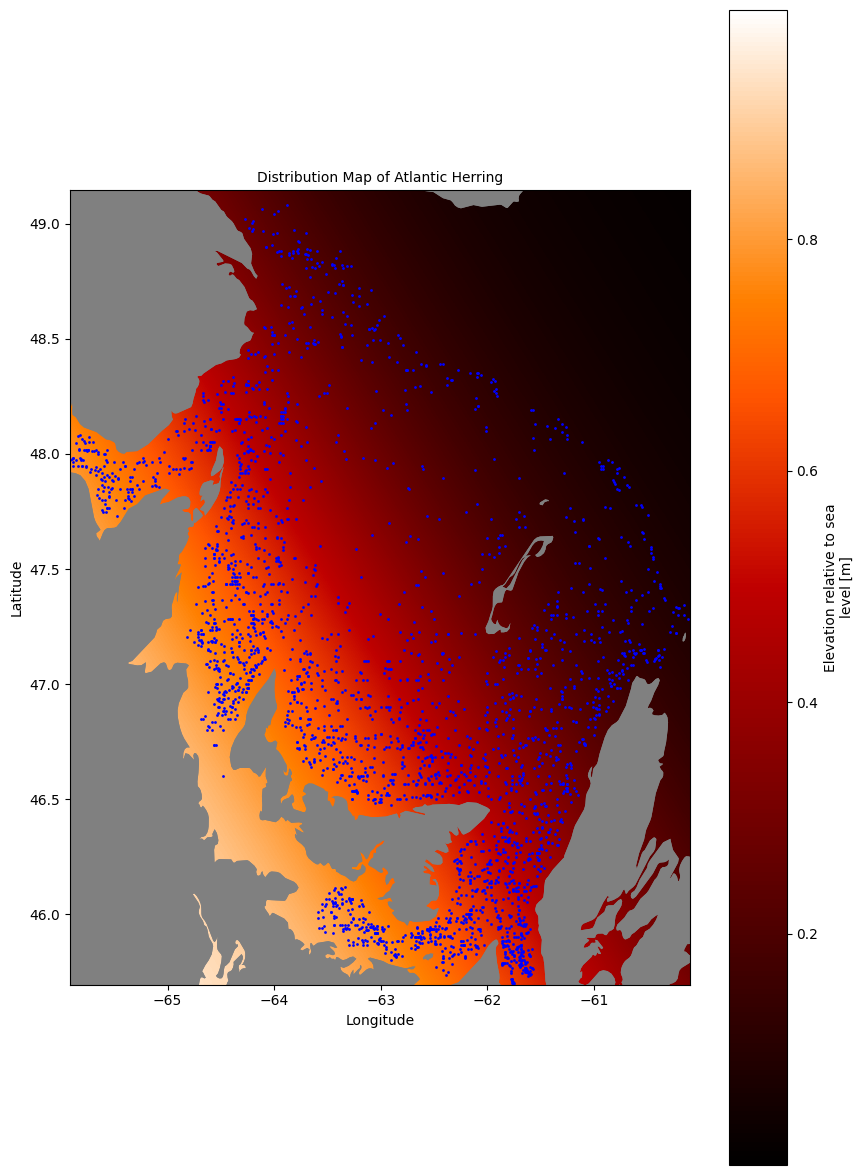

In [123]:
from geopandas import GeoDataFrame
from shapely import Point
import geopandas as gpd

fig, ax = plt.subplots(figsize=(10,15))

prob_xa.plot(ax=ax, cmap="gist_heat")

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)
gdf = gdf.set_crs(epsg=4326)

    
pmask = gdf[species] == True
amask = gdf[species] == False
gdf[pmask].plot(ax=ax, marker="o", color='blue', markersize=1, label="present")
# gdf[amask].plot(ax=ax, marker="o", color='red', markersize=1, label="absent")



# this geojson is from here: https://open.canada.ca/data/en/dataset/85efc01b-163f-ebba-2378-c43eadfb3b3f
canada = gpd.read_file("../data/Canada_Provinical_boundaries_April2022_3931220444258526365.geojson")
# it is in a weird projection
canada = canada.to_crs(epsg=4326)
# create the figure and plot

# start by plotting the two geospatial dfs
# gdf.plot(ax=ax, color='red', markersize=2)
canada.plot(ax=ax, color='grey')

# set graph props
ax.set_title(f'Distribution Map of {species.title()}', fontsize=10)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')  
ax.set_xlim((np.min(df["longitude"]),np.max(df["longitude"])))
ax.set_ylim((np.min(df["latitude"]),np.max(df["latitude"])))
